In [1]:
from sklearn.datasets import load_svmlight_file
import torch
import matplotlib.pyplot as plt

In [14]:
from torch.utils.data import Dataset, DataLoader
# LIBSVM dataset
class LIBSVM(torch.utils.data.Dataset):
    def __init__(self, path):
        super().__init__()
        # Load the dataset
        data, targets = load_svmlight_file(path, n_features = 123)

        # Convert targets for values in {0, 1}
        targets = (targets + 1) / 2
        
        # Convert to PyTorch tensors
        data = torch.from_numpy(data.toarray()).float()
        targets = torch.from_numpy(targets).float()

        self.data = data
        self.targets = targets
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    
# Create datasets and dataloaders
train_path = './libsvm_data/a9a.txt'
test_path = './libsvm_data/a9a_t.txt'

train_dataset = LIBSVM(train_path)
test_dataset = LIBSVM(test_path)

In [15]:
train_dataset.targets

tensor([0., 0., 0.,  ..., 0., 0., 1.])

In [21]:
class libsvm_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(123, 1)
    
    def forward(self, x):
        x = self.linear(x)
        return torch.sigmoid(x)


In [27]:
model = libsvm_model()
loss_fn = torch.nn.BCELoss()
X_1, y_1 = train_dataset[0]
X_2, y_2 = train_dataset[1]
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
X, y = next(iter(train_loader))
print(torch.equal(X[0], X_1))
print(torch.equal(X[1], X_2))
print(y)
print(y_1)
print(y_2)

True
True
tensor([0., 0.])
tensor(0.)
tensor(0.)


In [28]:
print("first loss", loss_fn(model(X_1), y_1.view(1)))
print("second loss", loss_fn(model(X_2), y_2.view(1)))
print("batch loss", loss_fn(model(X), y.view(-1, 1)))

first loss tensor(0.6065, grad_fn=<BinaryCrossEntropyBackward0>)
second loss tensor(0.6743, grad_fn=<BinaryCrossEntropyBackward0>)
batch loss tensor(0.6404, grad_fn=<BinaryCrossEntropyBackward0>)


In [5]:
def criterion(output, targets):
    # return a tensor of shape (1, 2), where [number of correct pred, batch_size]
    # Transform all values of preds to 0 (if value < 0.5) and 1
    preds = 1 * (output > torch.ones_like(output).mul_(0.5))
    
    return torch.tensor([(preds.view(1, -1).int() == targets.int()).sum(), len(targets)])

def evaluate(output, targets):
    accuracy = criterion(output, targets)
    return accuracy[0].item() / accuracy[1].item()

In [6]:
# Hyperparams
lr = 1e-5
weight_decay = 1e-5
batch_size = len(train_dataset)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
model = libsvm_model()
model.load_state_dict(torch.load('best_model_parameters.pth'))

# Loss and Optimizer
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.SGD(params= model.parameters(), lr = lr, weight_decay= weight_decay)

track_loss = []

In [7]:
# Training
epochs = 2000
model.train(True)
for epoch in range(epochs):
    # Gradient descent
    X, y = next(iter(train_dataloader))
    optimizer.zero_grad()
    loss = loss_fn(model(X), y.view(-1, 1))
    print(loss)
    loss.backward()
    optimizer.step()
    track_loss.append(loss.detach().numpy())

plt.plot(track_loss)
torch.save(model.state_dict(), 'best_model_parameters.pth')

tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3236, grad_fn=<Bina

KeyboardInterrupt: 

tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3646, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3645, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.3645, grad_fn=<Bina

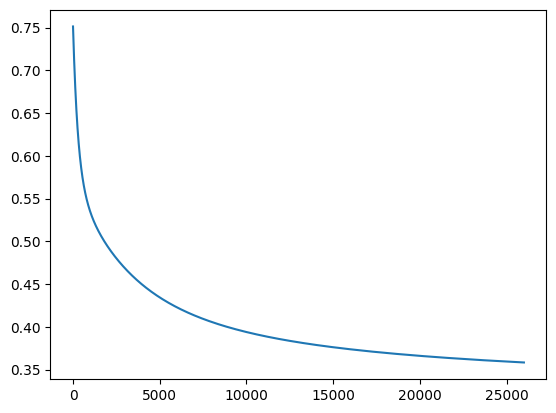

In [17]:
# Training continuity
epochs = 5000
for epoch in range(epochs):
    # Gradient descent
    X, y = next(iter(train_dataloader))
    optimizer.zero_grad()
    loss = loss_fn(model(X), y.view(-1, 1))
    print(loss)
    loss.backward()
    optimizer.step()
    track_loss.append(loss.detach().numpy())

plt.plot(track_loss)

In [18]:
# save model weights for more optimization
torch.save(model.state_dict(), 'best_model_parameters.pth')

# Load the model parameters from the file
loaded_model = libsvm_model()
loaded_model.load_state_dict(torch.load('best_model_parameters.pth'))

<All keys matched successfully>

In [75]:
# Testing
accuracy = torch.zeros(2)
model.eval()
for i, data in enumerate(test_dataloader):
    X, y = data
    accuracy += criterion(model(X), y)
    #print(loss_fn(model(X), y))
    #print(criterion(model(X), y))

print(f"The result of the evaluation over the test set is {accuracy[0].item() / accuracy[1].item()}")

The result of the evaluation over the test set is 0.850316319636386


In [13]:
t = [torch.tensor([1., 2.]), torch.tensor([2., 3.])]
torch.stack(t).mean(dim = 0)

tensor([1.5000, 2.5000])

### Finding optimal distributed loss

In [13]:
import misc, os, worker, dataset
from utils import dp_account, topology, plotting
import numpy as np

In [16]:
# Parameters
model = "libsvm_model"
dataset_name = "libsvm"
loss = "BCELoss"
num_nodes = 16
num_labels = 2
alpha = 1.
delta = 1e-5
target_eps = 10
num_iter = 3000
evaluation_delta = 5
gradient_clip = None
lr = 1e-1
weight_decay = 1e-5

misc.fix_seed(1)
# Create train and test dataloaders
train_loader_dict, test_loader = dataset.make_train_test_datasets(dataset=dataset_name, num_labels=num_labels, 
                                alpha_dirichlet= alpha, num_nodes=num_nodes, gradient_descent= True, train_batch=0, test_batch=100)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Initialize Workers
workers = []
for i in range(num_nodes):
    data_loader = train_loader_dict[i]
    worker_i = worker.Worker(train_data_loader=data_loader, test_data_loader=test_loader, batch_size=0, 
                model = model, loss = loss, momentum = 0., gradient_clip= gradient_clip, sigma= 0,
                num_labels= num_labels, criterion= "libsvm_topk", num_evaluations= 100, device= device, privacy = "user")
    workers.append(worker_i)

Proportions for label 1 [5.67441937e-02 1.33985226e-01 1.20281834e-05 3.78584368e-02
 1.66896786e-02 1.01881722e-02 2.16747261e-02 4.45847727e-02
 5.31526810e-02 8.13885253e-02 5.71368068e-02 1.21550690e-01
 2.40523382e-02 2.21327018e-01 2.92021483e-03 1.16734492e-01]


In [17]:
# Training
# Noise tensor: shape (num_nodes, num_nodes, model_size)
V = torch.zeros(num_nodes, workers[0].model_size).to(device)
# ------------------------------------------------------------------------ #
current_step = 0

# Training
while current_step <= num_iter:
    # Evaluate the model if milestone is reached
    milestone_evaluation = evaluation_delta > 0 and current_step % evaluation_delta == 0        
    if milestone_evaluation:
        mean_loss = np.mean([workers[i].compute_train_loss() for i in range(num_nodes)])
        print(mean_loss)
    # Apply the algorithm
    all_parameters = []

    # Step t + 1/2
    for i in range(num_nodes):
        param = workers[i].grad_descent(V, lr = lr, weight_decay = weight_decay)
    current_step += 1

0.7149819545447826
0.47421260830014944
0.4170828955247998
0.3914309530518949
0.37535734148696065
0.363521636929363
0.35407417779788375
0.3461958391126245
0.33945154887624085
0.33357719180639833
0.32839619636069983
0.3237823052331805
0.31964087951928377
0.3158986062044278
0.31249728612601757
0.3093898593215272
0.3065377495950088
0.30390893830917776
0.3014766408014111
0.2992181809968315
0.2971143327304162
0.29514855897286907
0.29330668062902987
0.2915763891651295
0.2899469526601024
0.28840900119394064
0.28695433208486065
0.2855756603530608
0.2842665716307238
0.28302136552520096
0.28183495037956163
0.2807027854141779
0.279620778048411
0.27858527144417167
0.27759296813746914
0.27664083865238354
0.2757261936785653
0.27484656346496195
0.27399970023543574
0.27318355679744855
0.2723962507152464
0.271636069053784
0.27090143962414004
0.27019088904489763
0.2695030870672781
0.2688368108938448
0.2681908887170721
0.267564291076269
0.26695601764367893
0.2663651540642604
0.2657908519322518
0.265232328